In [1]:
# Linear Regression 1440 dataset

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.metrics import mean_squared_error
import pickle

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier


In [4]:
file = '''RPT1106_data_1440.csv'''
data = pd.read_csv(file)
data.columns = ['timestamp', 'temperature', 'power', 'counter', 'time']
data.temperature = data.temperature.astype(float)
data.timer = data.counter.astype(int)
data.time = data.time.astype(int)
data.index = data.timestamp
data = data[['temperature', 'power', 'counter', 'time']]
data.head(5)

,temperature,power,counter,time
timestamp,,,,
1648076441095,63.8,0.0,95.0,0
1648076501095,63.8,0.0,96.0,100
1648076561095,63.8,0.0,97.0,200
1648076621095,63.8,0.0,98.0,300
1648076681095,63.3,0.0,99.0,400


In [5]:
train = data[:int(0.8*(len(data)))]
test = data[int(0.8*(len(data))):]
print(len(train), len(test))

31090 7773


In [6]:
train = train[['time', 'power', 'temperature']].to_numpy()
test = test[['time', 'power', 'temperature']].to_numpy()

In [7]:
# Scale features
s1 = MinMaxScaler(feature_range=(-1,1))
Xs = s1.fit_transform(train)
pickle.dump(s1, open('linearregression_MinMaxScaler_1440.s1', 'wb'))

# # Scale predicted value
s2 = MinMaxScaler(feature_range=(-1,1))
Ys = s2.fit_transform(train[:,[2]])
pickle.dump(s2, open('linearregression_MinMaxScaler_1440.s2', 'wb'))

In [8]:
# Each time step uses last 'window' to predict the next change
window = 1
X = []
Y = []
for i in range(window,len(Xs)):
    X.append(Xs[i-window:i,:])
    Y.append(Ys[i])

In [9]:
# Reshape data to format accepted by LSTM
X, Y = np.array(X), np.array(Y)

In [10]:
model = LinearRegression().fit(X[:, 0], Y[:, 0])
pickle.dump(model, open('linear_regression_1440.model', 'wb'))

In [11]:
x=90
t = '220000'
from datetime import datetime, date, timedelta

def getnexttime(currentTime):
    newTime = datetime.strptime(str(date.today()) + ' ' + str(currentTime), '%Y-%m-%d %H%M%S') + timedelta(minutes=1)
    return newTime.strftime('%H%M%S')

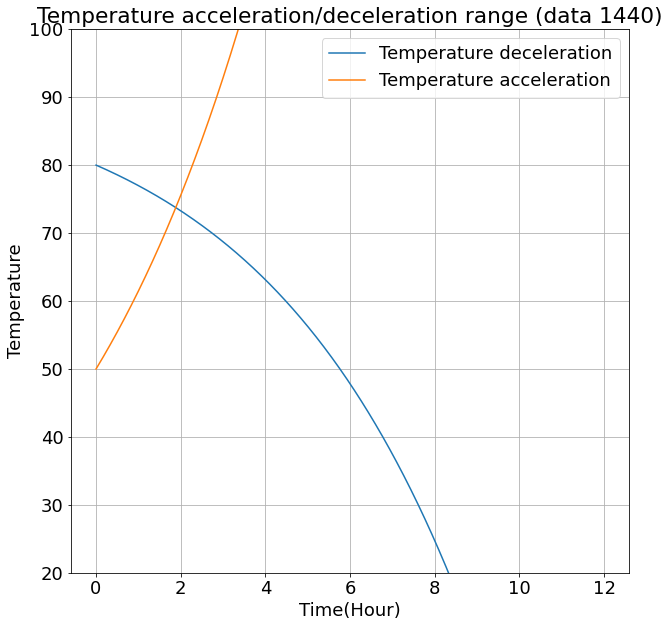

In [12]:
# test the prediction manually
plt.rcParams["figure.figsize"] = (10, 10)
plt.rcParams.update({'font.size': 18})

xx = [i/(60) for i in range(720)]

x = 80
temps = []
for i in range(720):
    temps.append(x)
#     t = getnexttime(t)
    transform = s1.transform([[t, 0, x]])
    ccc = model.predict([[transform[0][0], transform[0][1], transform[0][2] ]])
    x = s2.inverse_transform([ccc])[0][0]
plt.plot(xx, temps, label='Temperature deceleration')

x = 50
temps = []
for i in range(720):
    temps.append(x)
#     t = getnexttime(t)
    transform = s1.transform([[t, 1940, x]])
    ccc = model.predict([[transform[0][0], transform[0][1], transform[0][2] ]])
    x = s2.inverse_transform([ccc])[0][0]

plt.plot(xx, temps, label='Temperature acceleration')
plt.title('Temperature acceleration/deceleration range (data 1440)')
plt.ylabel('Temperature')
plt.xlabel('Time(Hour)')
plt.ylim(20, 100)
plt.legend(loc="upper right")
plt.grid()

In [13]:
# Predict validation set
Yp = model.predict(X[:, 0])
Y = Y[:, 0]

# un-scale outputs
Yu = s2.inverse_transform([Yp])[0]
Ym = s2.inverse_transform([Y])[0]

In [14]:
values = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6]
s = {}

for i in range(len(Yu)):
    flag = False
    for j in range(len(values[:-1])):
        x = np.round(abs(Yu[i] - Ym[i]), 1)
        if((x >= values[j]) and (x < values[j+1])):
            s[x] = s.get(x, 0) + 1
            flag = True
            break
    if(flag == False):
        s[1.6] = s.get(1.6, 0) + 1
        
s = dict(sorted((s.items())))
sumvalues = sum(s.values())

In [15]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

Text(0.5, 1.0, 'Power')

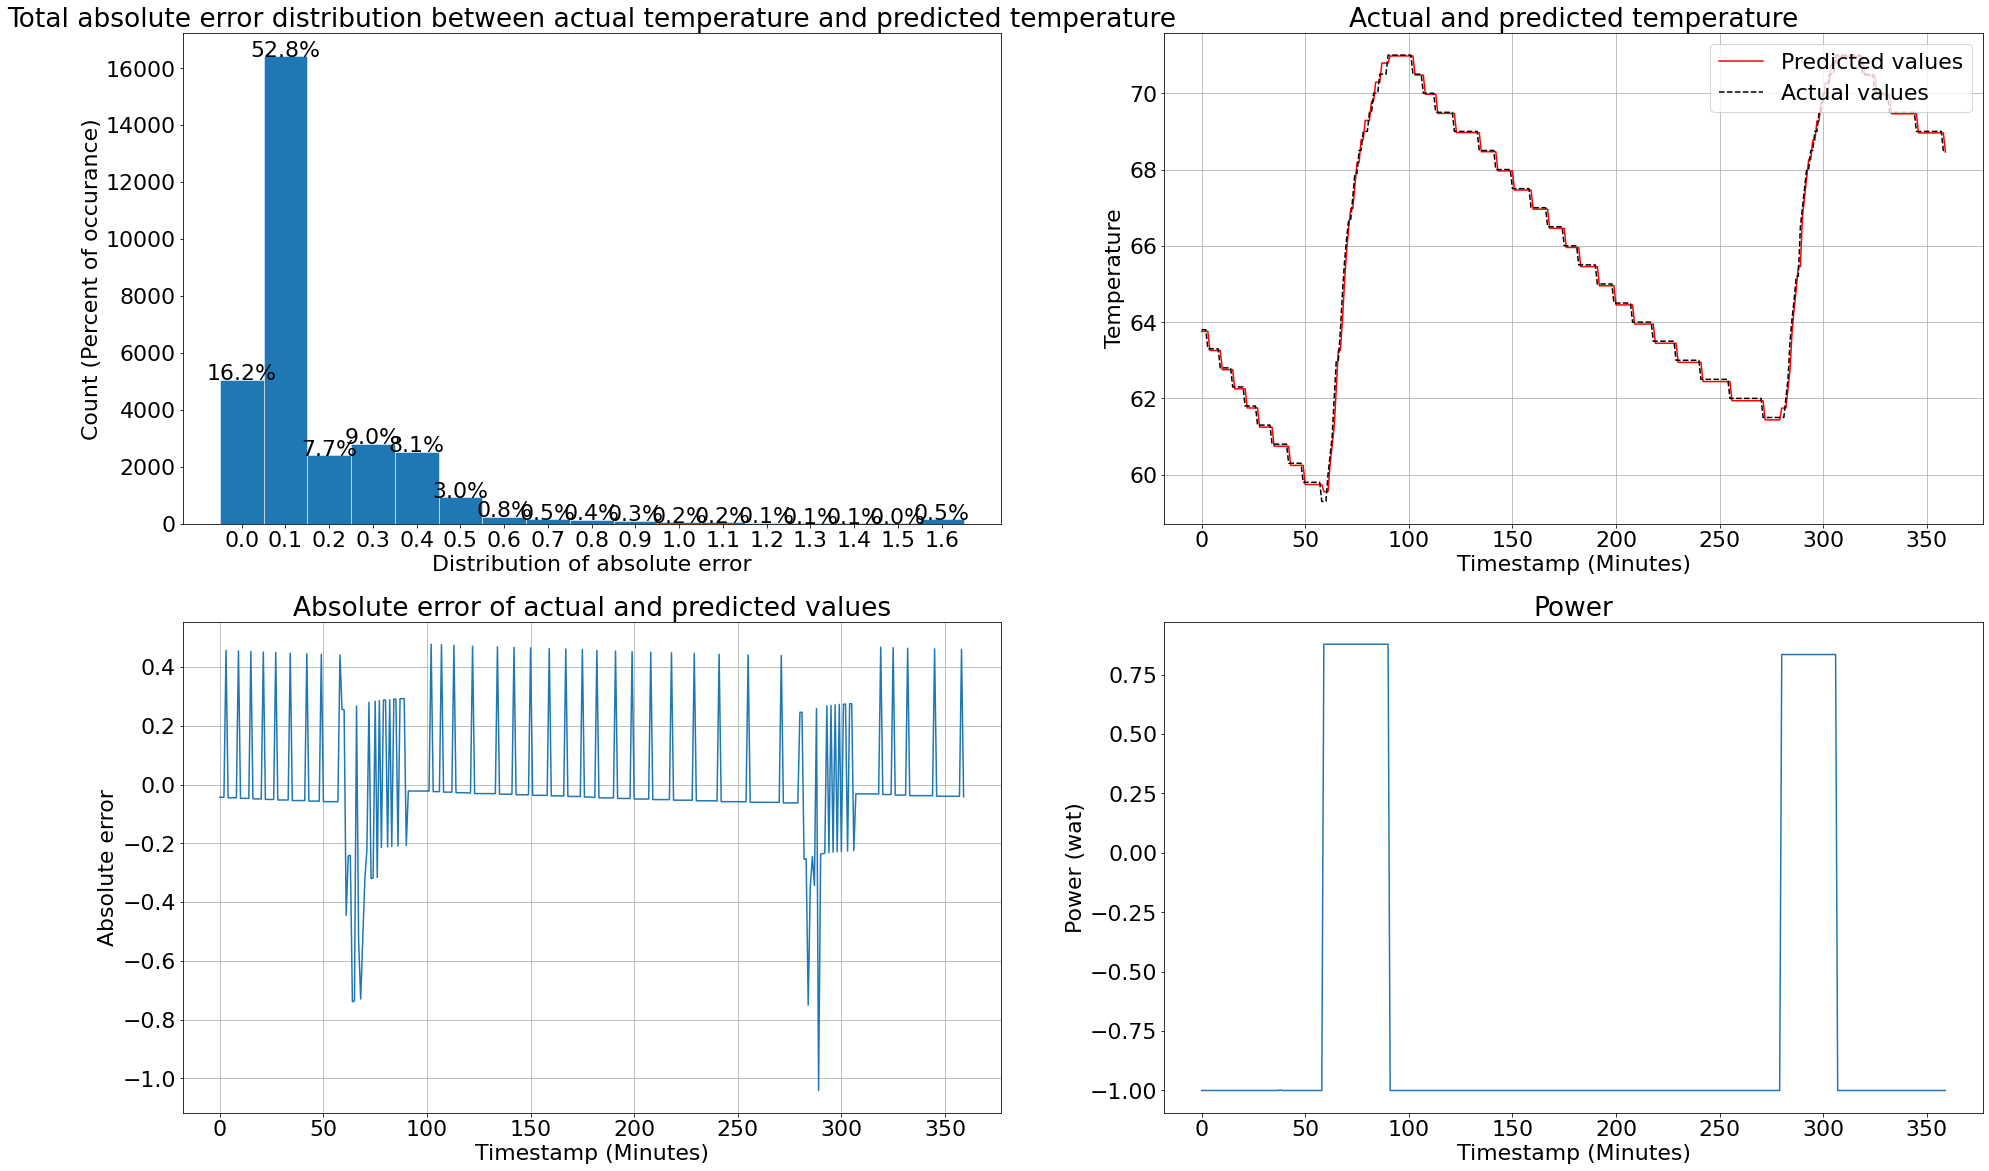

In [16]:
plt.rcParams.update({'font.size': 22})
fig, ((ax1, ax3), (ax2, ax4)) = plt.subplots(2,2, gridspec_kw=dict(left=0, right=1,
                                        bottom=0, top=1.5), figsize=(25, 10))

pps = ax1.bar(list(s.keys()), list(s.values()), label='xxxxxxxxxxx', width=0.1, edgecolor="white", linewidth=0.5)

for p in pps:
    height = p.get_height()
    ax1.text(x=p.get_x() + p.get_width() / 2, y = height+0.1, s="{}%".format(round(height/sumvalues*100, 1)), ha="center")
    
ax1.set_xticks(np.arange(0.0, 1.7, 0.1))
ax1.set_xlabel('Distribution of absolute error')
ax1.set_ylabel('Count (Percent of occurance)')
ax1.set_title("Total absolute error distribution between actual temperature and predicted temperature")

ax2.plot((Yu[0:360] - Ym[0:360]), label='Temperature') #NormalizeData
ax2.set_title("Absolute error of actual and predicted values")
ax2.set_xlabel('Timestamp (Minutes)')
ax2.set_ylabel('Absolute error')
ax2.grid()

ax3.plot(Yu[0:360], 'r-', label='Predicted values')
ax3.plot(Ym[0:360], 'k--', label='Actual values')
ax3.set_xlabel('Timestamp (Minutes)')
ax3.set_ylabel('Temperature')
ax3.set_title("Actual and predicted temperature")
ax3.legend(loc="upper right")
ax3.grid()

ax4.plot(X[:, :, 1][0:360])
ax4.set_xlabel('Timestamp (Minutes)')
ax4.set_ylabel('Power (wat)')
ax4.set_title("Power")

## test set

In [17]:
Xts = s1.transform(test)
Yts = s2.transform(test[:, [2]])

Xti = []
Yti = []
for i in range(window,len(Xts)):
    Xti.append(Xts[i-window:i,:])
    Yti.append(Yts[i])

# Reshape data to format accepted by LSTM
Xti, Yti = np.array(Xti), np.array(Yti)

# Verify the fit of the model
Ytp = model.predict(Xti[:, 0])
Yti = Yti[:, 0]

# un-scale outputs
Yu = s2.inverse_transform([Ytp])[0]
Ym = s2.inverse_transform([Yti])[0]

In [18]:
values = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6]
s = {}

for i in range(len(Yu)):
    flag = False
    for j in range(len(values[:-1])):
        x = np.round(abs(Yu[i] - Ym[i]), 1)
        if((x >= values[j]) and (x < values[j+1])):
            s[x] = s.get(x, 0) + 1
            flag = True
            break
    if(flag == False):
        s[1.6] = s.get(1.6, 0) + 1
        
s = dict(sorted((s.items())))

Text(0.5, 1.0, 'Power')

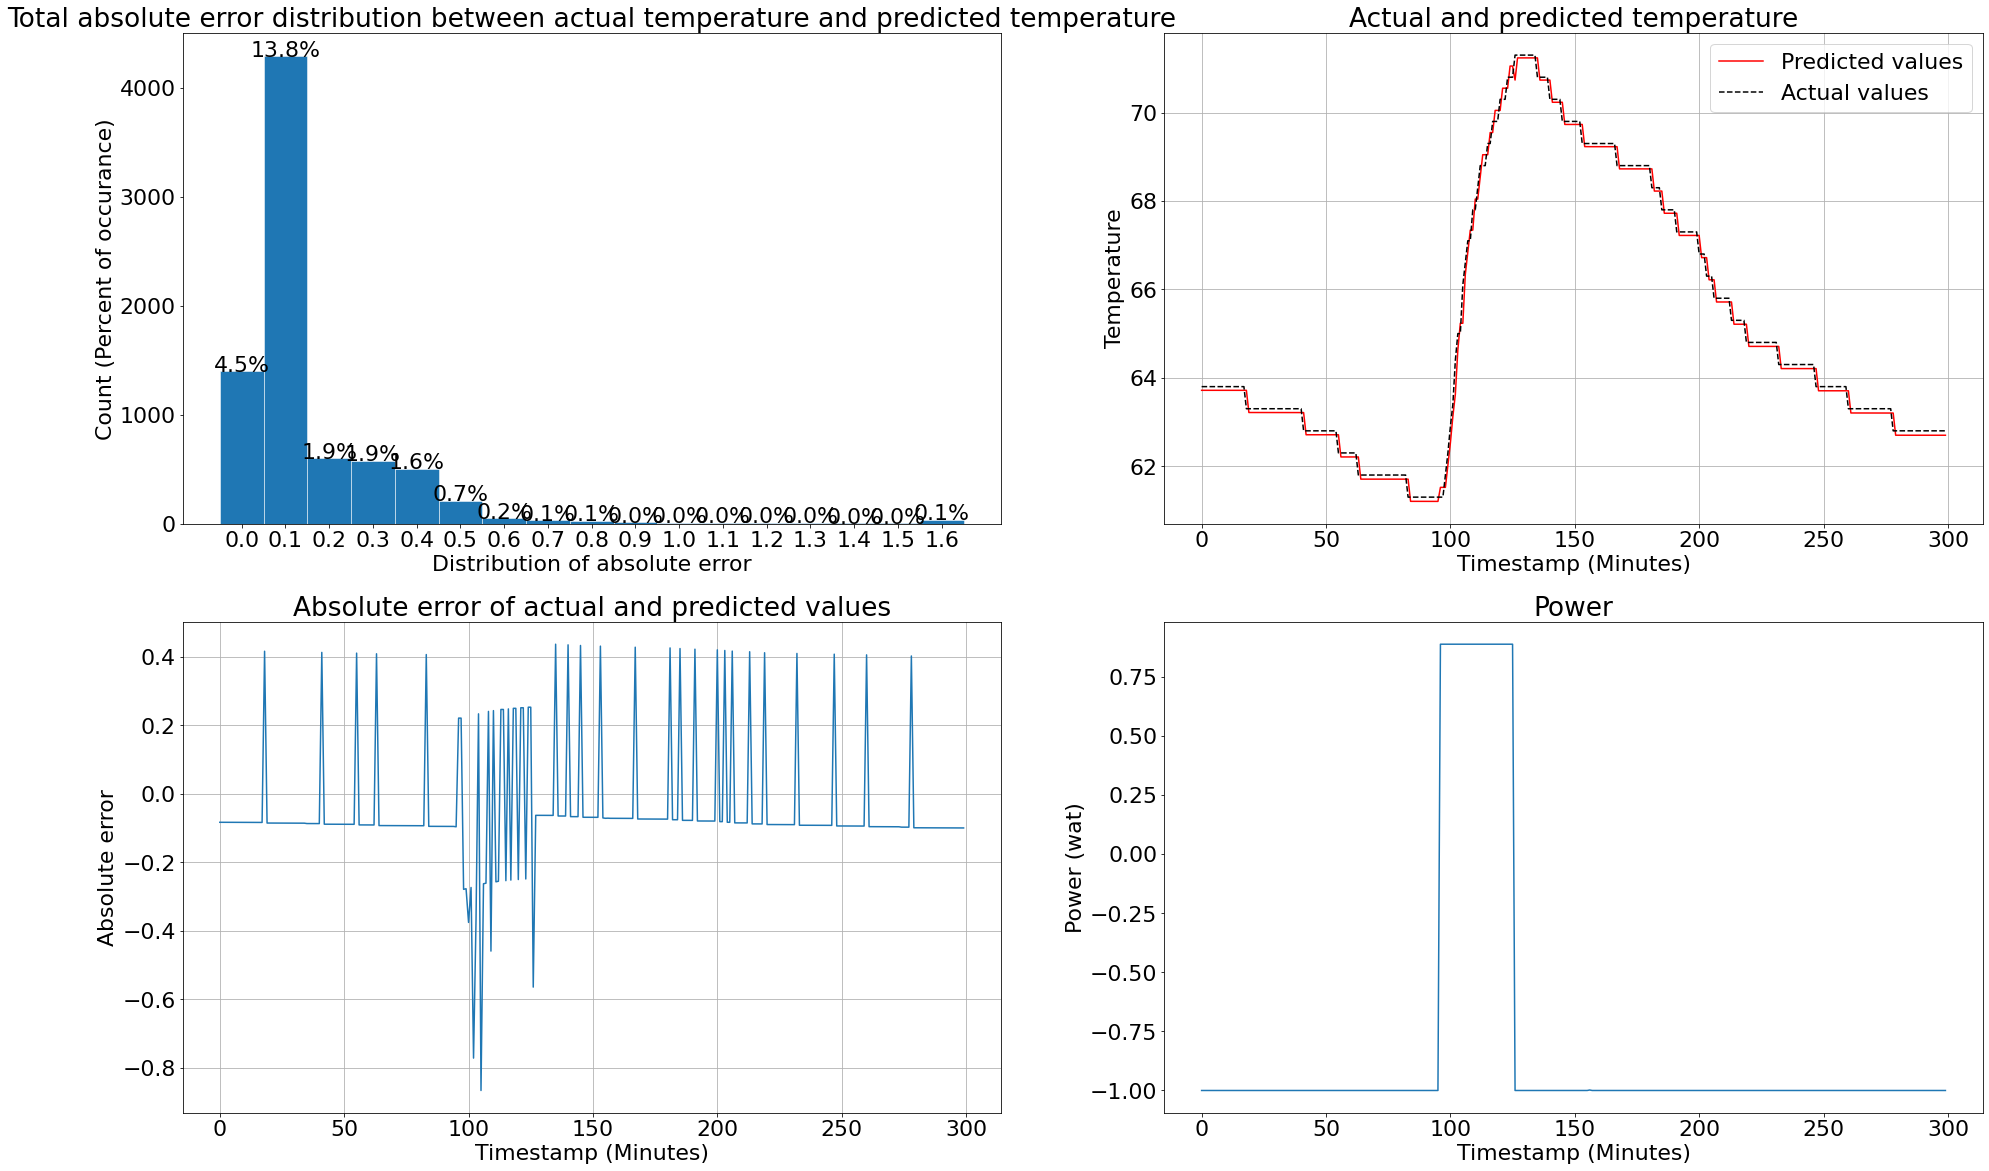

In [19]:
plt.rcParams.update({'font.size': 22})
fig, ((ax1, ax3), (ax2, ax4)) = plt.subplots(2,2, gridspec_kw=dict(left=0, right=1,
                                        bottom=0, top=1.5), figsize=(25, 10))

pps = ax1.bar(list(s.keys()), list(s.values()), label='xxxxxxxxxxx', width=0.1, edgecolor="white", linewidth=0.5)

for p in pps:
    height = p.get_height()
    ax1.text(x=p.get_x() + p.get_width() / 2, y = height+0.1, s="{}%".format(round(height/sumvalues*100, 1)), ha="center")
    
ax1.set_xticks(np.arange(0.0, 1.7, 0.1))
ax1.set_xlabel('Distribution of absolute error')
ax1.set_ylabel('Count (Percent of occurance)')
ax1.set_title("Total absolute error distribution between actual temperature and predicted temperature")

ax2.plot((Yu[60:360] - Ym[60:360]), label='Temperature') # NormalizeData
ax2.set_title("Absolute error of actual and predicted values")
ax2.set_xlabel('Timestamp (Minutes)')
ax2.set_ylabel('Absolute error')
ax2.grid()

ax3.plot(Yu[60:360], 'r-', label='Predicted values')
ax3.plot(Ym[60:360], 'k--', label='Actual values')
ax3.set_xlabel('Timestamp (Minutes)')
ax3.set_ylabel('Temperature')
ax3.set_title("Actual and predicted temperature")
ax3.legend(loc="upper right")
ax3.grid()

ax4.plot(Xts[:, 1][60:360])
ax4.set_xlabel('Timestamp (Minutes)')
ax4.set_ylabel('Power (wat)')
ax4.set_title("Power")